# Make movies of Hyades simulations in Eulerian coordinates, showing a variable of interest and marked material interfaces
Connor Krill September 2019

In [23]:
%matplotlib notebook

import os
import copy
import sys
sys.path.append("../tools") # for hyades_output_reader
from hyades_output_reader import createOutput
import numpy as np
from celluloid import Camera
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.patches import Polygon
plt.style.use("ggplot")
import pandas as pd
from scipy import interpolate


def getAlphaFromTV(file):
    if not file.endswith(".inf"):
        file += ".inf"
    # Read tv off inf
    with open(file) as f:
        contents = f.readlines()
    tv_lines = [[float(i) for i in line.split()[1:]] for line in contents if line.startswith("tv")]
    df = pd.DataFrame({"time":[tv[0]*1e9 for tv in tv_lines],
                       "value":[tv[1] for tv in tv_lines]}) # value are in hyades units
    # interpolate onto hyades.time
    f = interpolate.interp1d(df["time"], df["value"], kind="linear")
    mask = (hyades.time >= df.time.min()) & (hyades.time <= df.time.max())
    xnew = hyades.time[mask]
    ynew = f(xnew)
    if df.value.iat[-1] == 0:
        ynew[-1] = 0

    alpha = np.zeros(hyades.time.shape)
    alpha[mask] = ynew / ynew.max()
    return alpha

# Edit the file name and the color variable below. No need to edit the code in the cell underneath it.

In [24]:
# "./data/trackingDemo3/trackingDemo3"
# "./data/demoA/demoA"
# "./data/rampDemo/rampDemo"
file = "../data/testing1/testing1"
color_var = "Pres" # Pres, Te, Rho, U

<IPython.core.display.Javascript object>


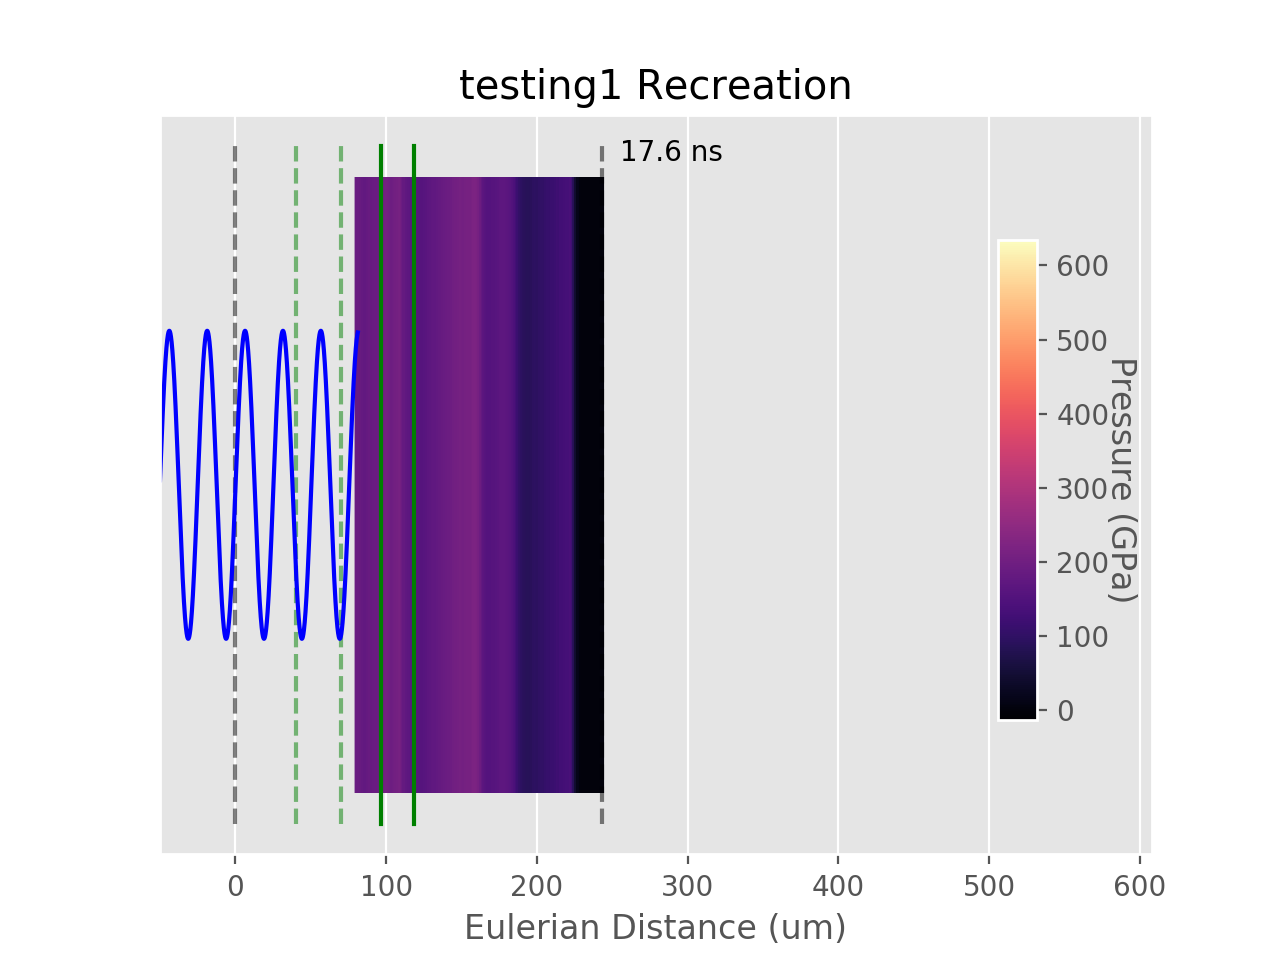

In [25]:
hyades = createOutput(file, "Particle Velocity")
X = copy.deepcopy(hyades.X)
    
colors_matrix = createOutput(file, color_var).output

if color_var=='Te':     label, units = 'Temperature', '(K)'
elif color_var=='Pres': label, units = 'Pressure', '(GPa)'
elif color_var=='U':    label, units = 'Particle Velocity', '(km/s)'
elif color_var=='Rho':  label, units = 'Density', '(g/cc)'
    
fig, ax = plt.subplots()
cbaxes = fig.add_axes([0.78, 0.25, 0.03, 0.5])
ax.set(title=f"{os.path.basename(file)} Recreation", xlabel="Eulerian Distance (um)",
       xlim=(-50, hyades.X.max() * 2.5), ylim=(-0.1, 1.1))
ax.yaxis.set_visible(False) 

alpha = getAlphaFromTV(file)

camera = Camera(fig)
for i in range(0, len(hyades.time)-2):
    # Plot initial position lines
    y = (-0.05, 1.05)
    ax.plot((hyades.X[0], hyades.X[0]), y, color="black", linestyle="dashed", alpha=0.5)
    ax.plot((hyades.X[-1], hyades.X[-1]), y, color="black", linestyle="dashed", alpha=0.5)
    for mat in list(hyades.material_properties.keys())[1:]:
        initial_x = hyades.material_properties[mat]["startX"]
        ax.plot((initial_x, initial_x), y, color="green", linestyle="dashed", alpha=0.5)
    ax.text(hyades.X[-1]*1.05, 1.025, f"{hyades.time[i]:.1f} ns", ha="left")
    
    # Update position of each mesh point
    dt = hyades.time[i+1] - hyades.time[i]
    delta_X = hyades.output[:len(hyades.X), i] * dt
    X += delta_X
    
    # Add mesh points to plot as lines
    lines = [np.array([[x, 0],[x, 1]]) for x in X]
    extra_color0 = np.array([[0, -1], [40, -1]])
    extra_color1 = np.array([[50, -1], [90, -1]])
    lines.append(extra_color0)
    lines.append(extra_color1)
    col = LineCollection(lines, cmap=plt.cm.magma)
    ax.add_collection(col)
    
    # Color each line based the values from the color variable
    colors = colors_matrix[:len(hyades.X), i]
    colors = np.concatenate((colors, [colors_matrix.max(), colors_matrix.min()]))
    col.set_array(colors)
    cb = fig.colorbar(col, cax = cbaxes)
    cb.set_label(f"{label} {units}", rotation=270, labelpad=10)
    
    # add material interfaces
    for mat in list(hyades.material_properties.keys())[1:]:
        mesh_ix = hyades.material_properties[mat]['startMesh'] - 1 
        line, = ax.plot((X[mesh_ix], X[mesh_ix]), (-0.05, 1.05), color='green')
    
    ### Set up the laser looking thing
    x = np.arange(ax.get_xlim()[0] - 1, X[0], step=0.01)
    amplitude = 0.25 * np.sin((0.25 * x) - 5*hyades.time[i])
#     amplitude = amplitude ** 0.5
    amplitude += 0.5
    ax.plot(x, amplitude, color="blue", lw=1.5, alpha=alpha[i])
#     anchor = X[0]
#     vertices = np.array([
#                         [ax.get_xlim()[0] - 1, 0.5 + 0.25*alpha[i]],
#                         [anchor,               0.5 + 0.25*alpha[i]],
#                         [anchor,               0.5 - 0.25*alpha[i]],
#                         [ax.get_xlim()[0] - 1, 0.5 - 0.25*alpha[i]]
#                        ])
#     polygon = Polygon(vertices, True)
#     p = PatchCollection([polygon], alpha=alpha[i], color="red")
#     ax.add_collection(p)
    camera.snap()
    
animation = camera.animate(interval=50, repeat=True)

# Run the cell below to save the animation

In [22]:
import matplotlib
Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)
out_fname = f"{os.path.basename(file)}_{color_var}_eulerian.mp4"
animation.save(f"../data/{out_fname}", dpi=200, writer=writer)

In [6]:
hyades.X

array([0.00000000e+00, 2.15698032e-04, 4.39161194e-04, 6.70669029e-04,
       9.10511146e-04, 1.15898758e-03, 1.41640916e-03, 1.68309793e-03,
       1.95938748e-03, 2.24562347e-03, 2.54216394e-03, 2.84937988e-03,
       3.16765559e-03, 3.49738922e-03, 3.83899326e-03, 4.19289505e-03,
       4.55953731e-03, 4.93937868e-03, 5.33289435e-03, 5.74057658e-03,
       6.16293537e-03, 6.60049907e-03, 7.05381507e-03, 7.52345044e-03,
       8.00999269e-03, 8.51405046e-03, 9.03625431e-03, 9.57725750e-03,
       1.01377368e-02, 1.07183934e-02, 1.13199536e-02, 1.19431699e-02,
       1.25888221e-02, 1.32577177e-02, 1.39506936e-02, 1.46686166e-02,
       1.54123848e-02, 1.61829287e-02, 1.69812121e-02, 1.78082338e-02,
       1.86650283e-02, 1.95526673e-02, 2.04722614e-02, 2.14249608e-02,
       2.24119574e-02, 2.34344859e-02, 2.44938254e-02, 2.55913012e-02,
       2.67282861e-02, 2.79062024e-02, 2.91265237e-02, 3.03907766e-02,
       3.17005426e-02, 3.30574602e-02, 3.44632268e-02, 3.59196009e-02,
      